# Create a NLP model for the topics in a given subreddit then train a regression model to predict the popularity and controversiality of a post

## Load packages

In [1]:
import os.path
from os import path
import sys
import ciso8601
import time
import datetime 
import requests
import json
import csv
import praw
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import gensim
import gensim.corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import common_corpus
from gensim.test.utils import datapath
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download('wordnet')
from textblob import TextBlob
import sklearn
import sklearn.model_selection as skmodsel
import sklearn.linear_model as sklinmod
import sklearn.ensemble as skensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import multiprocessing as mp
import pickle
import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dmartizzi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Experimental: Load data from a pickle file

In [2]:
#subrname = "politicaldiscussion"
#subrname = "history"
#subrname = "quotes"
subrname = "compsci"
#subrname = "changemyview"
#subrname = "parenting"

#inpath = "./"
#fname = "dump_r-"+subrname+"_2019-09-12.pkl"
inpath = "./subreddit_data/"
fname = inpath+"r-"+subrname+"-export.pkl"
dfraw = pd.read_pickle(fname)

# Filter out removed posts
sel = dfraw["selftext"].str.strip() == "[removed]"
dfraw["selftext"][sel] = ""
dfraw["title+selftext"] = dfraw["title"]+" "+dfraw["selftext"]
dfraw["Popularity"] = dfraw["score"]+dfraw["numComms"]
dfraw["Controversiality"] = 1.0-np.abs((dfraw["upvote_ratio"].values.astype(float)-0.5)/0.5)

# Filter out posts with less than 3 words
n_w = [len(dfraw["title+selftext"][i].split()) for i in range(0,len(dfraw["title+selftext"]))]
dfraw["n_words"] = n_w
sel = dfraw["n_words"] > 3
df = dfraw[sel]    

display(df)

,subreddit,sub_id,title,author,created,url,permalink,score,numComms,flair,selftext,upvote_ratio,title+selftext,Popularity,Controversiality,n_words
0,compsci,akof1,Gödel’s Incompleteness Theorems: a very readab...,sixbillionthsheep,2010-01-01 20:12:00,https://www.reddit.com/r/compsci/comments/akof...,/r/compsci/comments/akof1/gödels_incompletenes...,39,15,NaN,[*Originally posted at* */r/PhilosophyofScienc...,0.84,Gödel’s Incompleteness Theorems: a very readab...,54,0.32,647
1,compsci,al9cu,What is Computer Science?,greenrd,2010-01-03 21:47:12,http://vanemden.wordpress.com/2009/12/27/what-...,/r/compsci/comments/al9cu/what_is_computer_sci...,38,15,NaN,,0.82,What is Computer Science?,53,0.36,4
2,compsci,alhib,Why do computer scientists not pre-publish on ...,yggdrasilly,2010-01-04 11:22:54,http://nlpers.blogspot.com/2010/01/arxiv-and-n...,/r/compsci/comments/alhib/why_do_computer_scie...,47,19,NaN,,0.9,Why do computer scientists not pre-publish on ...,66,0.20,8
3,compsci,alvmz,An Approach to P=NP via Descriptive Complexity.,day_sweetener,2010-01-05 10:05:06,http://rjlipton.wordpress.com/2010/01/05/an-ap...,/r/compsci/comments/alvmz/an_approach_to_pnp_v...,32,1,NaN,,0.92,An Approach to P=NP via Descriptive Complexity.,33,0.16,7
4,compsci,alws3,A lambda calculus for quantum computation,seabre,2010-01-05 11:35:11,http://www.het.brown.edu/people/andre/qlambda/,/r/compsci/comments/alws3/a_lambda_calculus_fo...,24,1,NaN,,0.91,A lambda calculus for quantum computation,25,0.18,6
5,compsci,alymh,Can functional programming be liberated from t...,greenrd,2010-01-05 14:10:37,http://conal.net/blog/posts/can-functional-pro...,/r/compsci/comments/alymh/can_functional_progr...,37,19,NaN,,0.86,Can functional programming be liberated from t...,56,0.28,10
6,compsci,am1cy,Can someone explain me to the algorithms behin...,[deleted],2010-01-05 18:52:50,https://www.reddit.com/r/compsci/comments/am1c...,/r/compsci/comments/am1cy/can_someone_explain_...,14,5,NaN,[deleted],0.89,Can someone explain me to the algorithms behin...,19,0.22,26
7,compsci,amozz,"768-bit RSA , now officially not enough",pastr,2010-01-07 06:09:11,http://eprint.iacr.org/2010/006,/r/compsci/comments/amozz/768bit_rsa_now_offic...,68,20,NaN,,0.86,"768-bit RSA , now officially not enough",88,0.28,7
8,compsci,anfi5,"Turing's Cathedral, by George Dyson",qkdhfjdjdhd,2010-01-08 21:30:43,http://www.edge.org/3rd_culture/dyson05/dyson0...,/r/compsci/comments/anfi5/turings_cathedral_by...,19,4,NaN,,0.79,"Turing's Cathedral, by George Dyson",23,0.42,5
9,compsci,anoef,The Traveller's Dilemma : a dilemma for the fo...,sixbillionthsheep,2010-01-09 16:16:14,http://www.reddit.com/r/PhilosophyofScience/co...,/r/compsci/comments/anoef/the_travellers_dilem...,14,1,NaN,,0.75,The Traveller's Dilemma : a dilemma for the fo...,15,0.50,15


## Make plots for the the given subreddit 

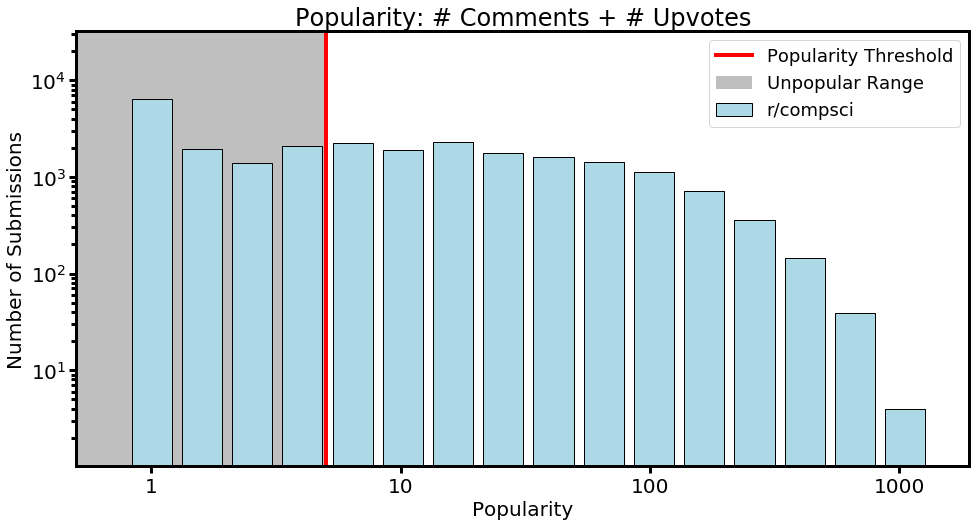

In [3]:
params={'font.size': 20,'axes.labelsize': 20,'legend.fontsize': 18,
        'xtick.labelsize': 20,'ytick.labelsize': 20,'lines.linewidth': 4,'axes.linewidth': 3,
        'xtick.major.width': 3,'ytick.major.width': 3,'xtick.minor.width': 3,'ytick.minor.width': 3,
        'xtick.major.size': 7,'ytick.major.size': 7,'xtick.minor.size': 5,'ytick.minor.size': 5,
        'lines.markeredgewidth' : 3, 'lines.markersize': 6}
mpl.rcParams.update(params)

plt.figure(figsize=(16,8))
plt.xscale("linear")
plt.yscale("log")
xmin = -0.3
xmedian = np.quantile(np.log10(df["Popularity"].values),0.5)
xmax = np.log10(np.max(df["Popularity"].values))
ymin = 1.01
isel = df["Popularity"].values == 1
ymax = 5*len(df["Popularity"].values[isel])
plt.axis([xmin,1.05*xmax,ymin,ymax])
plt.xlabel("Popularity")
plt.ylabel("Number of Submissions")
plt.xticks(np.arange(0,int(1.05*xmax)+1),labels=["%d"%(10**i) for i in np.arange(0,int(1.05*xmax)+1)])
plt.axvspan(-1, xmedian, facecolor='gray',alpha=0.5,label="Unpopular Range")
plt.hist(np.log10(df["Popularity"].values),bins=int((xmax-xmin)*5),range=[xmin,xmax],rwidth=0.8,color='lightblue',edgecolor='black',alpha=1,label="r/"+subrname)
plt.plot([xmedian,xmedian],[ymin,ymax],'r-',label="Popularity Threshold")
plt.title("Popularity: # Comments + # Upvotes")
plt.legend(loc=1)

figoutpath="./pre_rendered_plots"
plt.savefig(figoutpath+"/popularity_hist_r-"+subrname+".png")

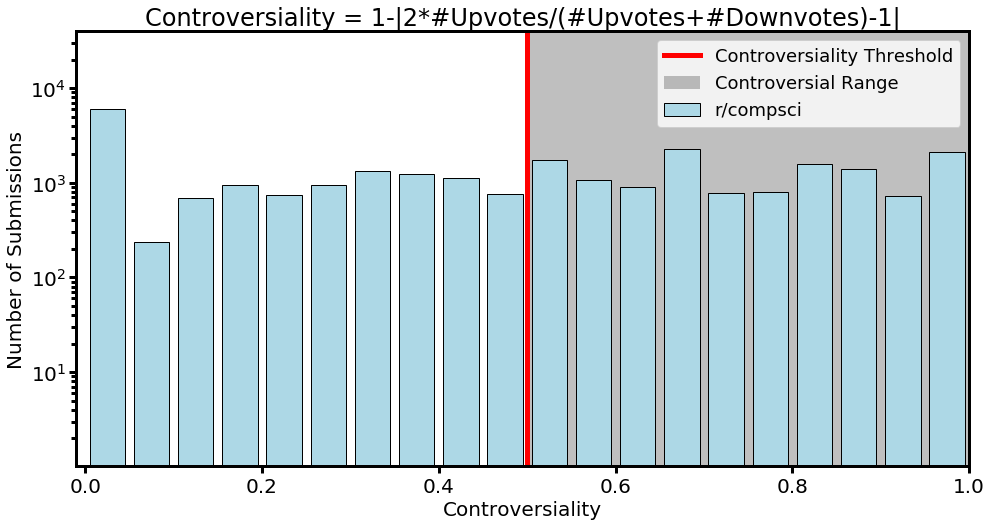

In [4]:
fig = plt.figure(figsize=(16,8))
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("Controversiality")
plt.ylabel("Number of Submissions")
ymin = 1.01
isel = df["Controversiality"].values < 0.2
ymax = 5.*len(df["Controversiality"].values[isel])
plt.axis([-0.01,1.0,ymin,ymax])
plt.xticks(np.arange(0,1.2,0.2),labels=["0.0","0.2","0.4","0.6","0.8","1.0"])
plt.axvspan(0.5, 1.0, facecolor='gray',alpha=0.5,label="Controversial Range")
plt.plot([0.5,0.5],[0,1e8],"r-",linewidth=5,label="Controversiality Threshold")
histdata = [df["Controversiality"].values]
plt.hist(histdata,bins=20,range=[0,1],rwidth=0.8,color='lightblue',edgecolor='black',alpha=1,label="r/"+subrname)
plt.title("Controversiality = 1-|2*#Upvotes/(#Upvotes+#Downvotes)-1|")
plt.legend(loc=1)
figoutpath="./pre_rendered_plots"
plt.savefig(figoutpath+"/popularity_hist_r-"+subrname+".png")

## Preprocess the submissions 

In [5]:
def lemmatize_stemming(text):
    '''Function to lemmatize text'''
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [6]:
def preprocess(text):
    '''Function to pre-process text'''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
# Preprocess titles 
processed_subm = df["title+selftext"].map(preprocess)

# Experimental: load LDA model or create it if it doesn't exist

In [ ]:
# Create Bag of Words 
dictionary = gensim.corpora.Dictionary(processed_subm)

# Filter out irrelevant words 
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=5000)

# For each tweet, create a dictionary reporting how many
# words and how many times those words appear.
bow_corpus = [dictionary.doc2bow(subm) for subm in processed_subm]

In [ ]:
if path.exists("lda_models"):
    print("Directory lda_models exists!")
else:
    !mkdir lda_models
    print("Directory lda_models created!")

In [ ]:
# Choose number of topics for LDA
num_topics_lda = 10

In [ ]:
outpath = "./lda_models/"
ldaoutfile = outpath+"lda_model_prod_r-"+subrname
if path.exists(ldaoutfile):
    print(ldaoutfile+"model exists!")
    lda_model = gensim.models.LdaModel.load(ldaoutfile)
else :
    # Create Latent Dirichlet Allocation model with a given number of topics
    ncores = mp.cpu_count()
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics_lda, id2word=dictionary, \
                passes=10, workers=ncores)
    # Save LDA model to disc (it's expensive to regenerate)
    lda_model.save(ldaoutfile)

## Perform exploratory data analysis with the LDA model

In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [ ]:
lda_topics_df = get_lda_topics(lda_model, num_topics_lda)
lda_topics_df.head(10)

In [ ]:
# Test LDA model
test_strings = {"test_strings" : list(df["title+selftext"].values)}
df_test_strings = pd.DataFrame(data = test_strings)

# Same procedure as above
processed_test_strings = df_test_strings["test_strings"].map(preprocess)
test_corpus = [dictionary.doc2bow(text) for text in processed_test_strings]
raw = lda_model[test_corpus]
shape = (len(raw),num_topics_lda)
predicted_topic_lda = np.zeros(shape)
for i,tups in enumerate(raw):
    for j in range(0,len(tups)):
        predicted_topic_lda[i,j] = tups[j][1]
    #print(df_test_strings["test_strings"].iloc[i],predicted_topic_lda[i],"\n")

# Experimental: load NMF model or create it if it doesn't exist

In [8]:
if path.exists("nmf_models"):
    print("Directory nmf_models exists!")
else:
    !mkdir nmf_models
    print("Directory nmf_models created!")

Directory nmf_models exists!


In [9]:
# Number of topics for NMF
num_topics_nmf = 40

In [10]:
# Create sentences
processed_subm_sentences = [' '.join(text) for text in processed_subm]

# Word counts
outpath = "./nmf_models/"
outfile = outpath+"count_vectorizer_prod_r-"+subrname
if path.exists(outfile):
    print(outfile+"model exists!")
    vectorizer = pickle.load(open(outfile, 'rb'))    
    x_counts = vectorizer.transform(processed_subm_sentences)
else:
    vectorizer = CountVectorizer(analyzer='word', max_features=5000)
    x_counts = vectorizer.fit_transform(processed_subm_sentences)
    pickle.dump(vectorizer, open(outfile, 'wb'))
    
# TF-IDF transform
outpath = "./nmf_models/"
outfile = outpath+"tfidf_transformer_prod_r-"+subrname
if path.exists(outfile):
    print(outfile+"model exists!")
    transformer = pickle.load(open(outfile, 'rb')) 
    x_tfidf = transformer.transform(x_counts)
else:
    transformer = TfidfTransformer(smooth_idf=True)
    x_tfidf = transformer.fit_transform(x_counts)
    pickle.dump(transformer, open(outfile, 'wb'))

# Normalize to unit length
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

./nmf_models/count_vectorizer_prod_r-compscimodel exists!
./nmf_models/tfidf_transformer_prod_r-compscimodel exists!


In [11]:
outpath = "./nmf_models/"
nmfoutfile = outpath+"nmf_model_prod_r-"+subrname
if path.exists(nmfoutfile):
    print(nmfoutfile+"model exists!")
    nmf_model = pickle.load(open(nmfoutfile, 'rb'))
else :
    # Create NMF model.
    nmf_model = NMF(n_components=num_topics_nmf,init='nndsvd',alpha=0.1)
    # Fit the model
    nmf_model.fit(xtfidf_norm)
    # Save NMF model to disc (it's expensive to regenerate)
    pickle.dump(nmf_model, open(nmfoutfile, 'wb'))

./nmf_models/nmf_model_prod_r-compscimodel exists!


In [12]:
def get_nmf_topics(model, n_top_words, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {}
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    
    return pd.DataFrame(word_dict)

In [13]:
nmf_topics_df = get_nmf_topics(nmf_model, 10, num_topics_nmf)
nmf_topics_df.head(10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 31,Topic # 32,Topic # 33,Topic # 34,Topic # 35,Topic # 36,Topic # 37,Topic # 38,Topic # 39,Topic # 40
0,scienc,delet,learn,help,program,comput,algorithm,major,time,softwar,...,build,class,differ,best,need,scientist,proof,compsci,network,cours
1,theoret,drive,machin,assign,post,quantum,sort,minor,polynomi,engin,...,game,complex,system,laptop,advic,histori,complex,student,neural,onlin
2,mathemat,school,deep,homework,function,complex,visual,doubl,complex,test,...,python,colleg,explain,python,know,consid,mathemat,colleg,artifici,free
3,engin,idea,resourc,understand,dynam,cloud,search,colleg,real,search,...,reader,take,engin,colleg,mathemat,greatest,theorem,year,intellig,colleg
4,student,point,python,java,challeng,model,graph,laptop,run,tool,...,applic,semest,type,place,seex,librari,method,want,gener,udemi
5,colleg,worth,start,choos,write,gener,explain,switch,linear,architectur,...,websit,school,inform,paper,suggest,mathematician,claim,advic,deep,choos
6,rank,compani,year,need,python,futur,design,go,hard,master,...,databas,teach,oper,intellig,guidanc,think,equal,school,introduct,live
7,school,experi,want,littl,model,think,complex,right,graduat,convert,...,distribut,like,object,artifici,oper,better,come,think,system,complet
8,teach,tree,scratch,discret,java,distribut,implement,choos,upgrad,hardwar,...,hacker,fail,understand,beginn,asap,mainstream,prove,go,oper,coursera
9,philosophi,startup,guid,guy,orient,parallel,genet,physic,integ,design,...,resourc,offer,window,resourc,choos,critic,feel,undergrad,secur,recommend


In [14]:
from scipy import sparse

# Test NMF model
test_strings = {"test_strings" : df["title+selftext"].values}
df_test_strings = pd.DataFrame(data = test_strings)

# Same procedure as above
processed_test_strings = df_test_strings["test_strings"].map(preprocess)
test_sentences = [' '.join(text) for text in processed_test_strings]
x_test_counts = vectorizer.transform(test_sentences)
x_test_tfidf = transformer.transform(x_test_counts)
xtfidf_test_norm = normalize(x_test_tfidf, norm='l1', axis=1)
y = nmf_model.transform(xtfidf_test_norm)
predicted_topic_nmf = normalize(y, norm='l1', axis=1)
#for i in range(0,len(predicted_topic_nmf)):
#    print(df_test_strings["test_strings"].iloc[i],predicted_topic_nmf[i])

# Sentiment analysis with TextBlob

In [15]:
sentiment = np.empty((predicted_topic_nmf[:,0].shape[0],2))
for i,sentence in enumerate(processed_subm_sentences):
    proc = TextBlob(sentence)
    sentiment[i,0] = proc.sentiment[0]
    sentiment[i,1] = proc.sentiment[1]

# Experimental: perform regression only with topics to predict popularity and controversiality

## Setup the Popularity and Controversiality 

In [ ]:
# Build labels and features

features = predicted_topic_nmf

# Popularity of a post
p = [0] * len(df["Popularity"].values)
popular = np.array(p); del p
cutoff_pop = np.quantile(df["Popularity"].values,q=0.5)
selp0 = df["Popularity"].values > cutoff_pop
popular[selp0] = 1
popular = popular.astype(int)

# Controversiality of a post
c = [0] * len(df["upvote_ratio"].values)
controversial = np.array(c); del c
inf = 0.25
sup = 0.75
selc0 = np.logical_and(inf <= df["upvote_ratio"].values.astype(float), \
                       df["upvote_ratio"].values.astype(float) <= sup)
controversial[selc0] = 1
selc1 = np.logical_or(df["upvote_ratio"].values.astype(float) < inf, \
                      df["upvote_ratio"].values.astype(float) > sup)
controversial = controversial.astype(int)

Fpop = float(len(popular[selp0])/len(popular))
Fcon = float(len(controversial[selc0])/len(controversial))

print("Fraction of Popular Posts = ",float(len(popular[selp0])/len(popular)))
print("Fraction of Controversial Posts = ",float(len(controversial[selc0])/len(controversial)))

## Split in training, testing and validation sets

In [ ]:
test_size = 0.2
validation_size = 0.2
train_size = 1.0 - test_size - validation_size

X, featurep_test, Y, popular_test = \
    skmodsel.train_test_split(features,popular,test_size=test_size,stratify=popular)
featurep_train, featurep_validation, popular_train, popular_validation = \
    skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)

X, featurec_test, Y, controversial_test = \
    skmodsel.train_test_split(features,controversial,test_size=test_size,stratify=controversial)
featurec_train, featurec_validation, controversial_train, controversial_validation = \
    skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)

del X,Y

## Create and train Logistic Regression models

These models are robust but do not achieve top precision.

In [ ]:
wp = [1.0] * featurep_train.shape[0]
weight_pop = np.array(wp); del wp
selp0 = weight_pop == 0
weight_pop[selp0] = Fpop
#weight_pop = {0: Fpop, 1: 1.0}

wc = [1.0] * featurec_train.shape[0]
weight_con = np.array(wc); del wc
selc1 = weight_con == 0
weight_con[selc1] = Fcon
#weight_pop = {0: Fcon, 1: 1.0}

popular_logregmodel = sklinmod.LogisticRegression()
controversial_logregmodel = sklinmod.LogisticRegression()
popular_logregmodel = popular_logregmodel.fit(featurep_train,popular_train, \
                            sample_weight=weight_pop)
controversial_logregmodel = controversial_logregmodel.fit(featurec_train,controversial_train, \
                            sample_weight=weight_con)

pred_pop_train = popular_logregmodel.predict(featurep_train)
pred_pop_test = popular_logregmodel.predict(featurep_test)
pred_pop_val = popular_logregmodel.predict(featurep_validation)
pred_con_train = popular_logregmodel.predict(featurec_train)
pred_con_test = popular_logregmodel.predict(featurec_test)
pred_con_val = popular_logregmodel.predict(featurec_validation)

prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)

print("Logistic regression for Popularity. Score on Training Set = ", prec_pop_train)
print("Logistic regression for Popularity. Score on Test Set = ", prec_pop_test)
print("Logistic regression for Popularity. Score on Validation Set = ", prec_pop_val,"\n")

print("Logistic regression for Controversiality. Score on Training Set = ", prec_con_train)
print("Logistic regression for Controversiality. Score on Training Set = ", prec_con_test)
print("Logistic regression for Controversiality. Score on Training Set = ", prec_con_val,"\n")

#outpath = "./regression_models/"
#outname = outpath+"lorgreg_scores_nmf_prod_r-"+subrname+".csv"
#with open(outname, 'w') as csvfile:
#    writer = csv.writer(csvfile,delimiter=",")
#    writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
#                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
#                    "PopFraction","ConFraction"])
#    writer.writerow([str(prec_pop_train), \
#                    str(prec_pop_test), \
#                    str(prec_pop_val), \
#                    str(prec_con_train), \
#                    str(prec_con_test), \
#                    str(prec_con_val), \
#                    str(Fpop),str(Fcon)])
#
#scores = pd.read_csv(outname)
#display(scores)

## Save Logistic Regression models

In [ ]:
# Save regression model to disc 
outpath = "./regression_models/"
fname = outpath+"logreg_popular_from_nmf_prod_r-"+subrname
pickle.dump(popular_logregmodel, open(fname, 'wb'))
fname = outpath+"logreg_controversial_from_nmf_prod_r-"+subrname
pickle.dump(controversial_logregmodel, open(fname, 'wb'))

## Create and train Random Forests models

These models seem to overfit.

In [ ]:
wp = [1.0] * featurep_train.shape[0]
weight_pop = np.array(wp); del wp
selp0 = weight_pop == 0
weight_pop[selp0] = Fpop
#weight_pop = {0: Fpop, 1: 1.0}

wc = [1.0] * featurec_train.shape[0]
weight_con = np.array(wc); del wc
selc1 = weight_con == 0
weight_con[selc1] = Fcon
#weight_pop = {0: Fcon, 1: 1.0}

popular_rforestmodel = skensemble.RandomForestRegressor( \
                        n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
controversial_rforestmodel = skensemble.RandomForestRegressor( \
                        n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

popular_rforestmodel = popular_rforestmodel.fit(featurep_train,popular_train, \
                       sample_weight=weight_pop)
controversial_rforestmodel = controversial_rforestmodel.fit(featurec_train,controversial_train, \
                             sample_weight=weight_con)

pred_pop_train = np.rint(popular_rforestmodel.predict(featurep_train))
pred_pop_test = np.rint(popular_rforestmodel.predict(featurep_test))
pred_pop_val = np.rint(popular_rforestmodel.predict(featurep_validation))
pred_con_train = np.rint(popular_rforestmodel.predict(featurec_train))
pred_con_test = np.rint(popular_rforestmodel.predict(featurec_test))
pred_con_val = np.rint(popular_rforestmodel.predict(featurec_validation))

prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)

print("Random Forest for Popularity. Score on Training Set = ", prec_pop_train)
print("Random Forest for Popularity. Score on Test Set = ", prec_pop_test)
print("Random Forest for Popularity. Score on Validation Set = ", prec_pop_val,"\n")

print("Random Forest for Controversiality. Score on Training Set = ", prec_con_train)
print("Random Forest for Controversiality. Score on Training Set = ", prec_con_test)
print("Random Forest for Controversiality. Score on Training Set = ", prec_con_val,"\n")

outpath = "./regression_models/"
outname = outpath+"rforest_scores_nmf_prod_r-"+subrname+".csv"
with open(outname, 'w') as csvfile:
    writer = csv.writer(csvfile,delimiter=",")
    writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
                    "PopFraction","ConFraction"])
    writer.writerow([str(prec_pop_train), \
                    str(prec_pop_test), \
                    str(prec_pop_val), \
                    str(prec_con_train), \
                    str(prec_con_test), \
                    str(prec_con_val), \
                    str(Fpop),str(Fcon)])

## Create and train Gradient Boosting models

These models are robust and achieve best precision.

In [ ]:
wp = [1.0] * featurep_train.shape[0]
weight_pop = np.array(wp); del wp
selp0 = weight_pop == 0
weight_pop[selp0] = Fpop
#weight_pop = {0: Fpop, 1: 1.0}

wc = [1.0] * featurec_train.shape[0]
weight_con = np.array(wc); del wc
selc1 = weight_con == 0
weight_con[selc1] = Fcon
#weight_pop = {0: Fcon, 1: 1.0}

popular_gboost = skensemble.GradientBoostingRegressor( \
                        n_estimators=100, learning_rate=0.1, random_state=0)
controversial_gboost = skensemble.GradientBoostingRegressor( \
                        n_estimators=100, learning_rate=0.1, random_state=0)

popular_gboost = popular_gboost.fit(featurep_train,popular_train, \
                       sample_weight=weight_pop)
controversial_gboost = controversial_gboost.fit(featurec_train,controversial_train, \
                       sample_weight=weight_con)

pred_pop_train = np.rint(popular_gboost.predict(featurep_train)).astype(int)
pred_pop_test = np.rint(popular_gboost.predict(featurep_test)).astype(int)
pred_pop_val = np.rint(popular_gboost.predict(featurep_validation)).astype(int)
pred_con_train = np.rint(popular_gboost.predict(featurec_train)).astype(int)
pred_con_test = np.rint(popular_gboost.predict(featurec_test)).astype(int)
pred_con_val = np.rint(popular_gboost.predict(featurec_validation)).astype(int)

prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)

print("Gradient Boost for Popularity. Score on Training Set = ", prec_pop_train)
print("Gradient Boost for Popularity. Score on Test Set = ", prec_pop_test)
print("Gradient Boost for Popularity. Score on Validation Set = ", prec_pop_val,"\n")

print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_train)
print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_test)
print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_val,"\n")

#outpath = "./regression_models/"
#outname = outpath+"gboost_scores_nmf_prod_r-"+subrname+".csv"
#with open(outname, 'w') as csvfile:
#    writer = csv.writer(csvfile,delimiter=",")
#    writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
#                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
#                    "PopFraction","ConFraction"])
#    writer.writerow([str(prec_pop_train), \
#                    str(prec_pop_test), \
#                    str(prec_pop_val), \
#                    str(prec_con_train), \
#                    str(prec_con_test), \
#                    str(prec_con_val), \
#                    str(Fpop),str(Fcon)])

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[sklearn.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    params={'font.size': 20,'axes.labelsize': 20,'legend.fontsize': 18,
        'xtick.labelsize': 20,'ytick.labelsize': 20,'lines.linewidth': 4,'axes.linewidth': 3,
        'xtick.major.width': 3,'ytick.major.width': 3,'xtick.minor.width': 3,'ytick.minor.width': 3,
        'xtick.major.size': 7,'ytick.major.size': 7,'xtick.minor.size': 5,'ytick.minor.size': 5,
        'lines.markeredgewidth' : 3, 'lines.markersize': 6, 'figure.figsize': (8,8)}
    mpl.rcParams.update(params)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [ ]:
class_names = ["Unpopular", "Popular"]

plot_confusion_matrix(popular_train, pred_pop_train, classes=class_names, normalize=True,
                      title='Training Set')

plot_confusion_matrix(popular_test, pred_pop_test, classes=class_names, normalize=True,
                      title='Test Set')

plot_confusion_matrix(popular_validation, pred_pop_val, classes=class_names, normalize=True,
                      title='Validation Set')

# Experimental: perform regression including topics and sentiment features

## Setup the Popularity and Controversiality 

In [ ]:
# Build labels and features
features = np.concatenate((predicted_topic_nmf,sentiment),axis=1)

# Popularity of a post
p = [0] * len(df["Popularity"].values)
popular = np.array(p); del p
cutoff_pop = np.quantile(df["Popularity"].values,q=0.5)
selp0 = df["Popularity"].values > cutoff_pop
popular[selp0] = 1

# Controversiality of a post
c = [0] * len(df["upvote_ratio"].values)
controversial = np.array(c); del c
inf = 0.25
sup = 0.75
selc0 = np.logical_and(inf <= df["upvote_ratio"].values.astype(float), \
                       df["upvote_ratio"].values.astype(float) <= sup)
controversial[selc0] = 1
selc1 = np.logical_or(df["upvote_ratio"].values.astype(float) < inf, \
                      df["upvote_ratio"].values.astype(float) > sup)

Fpop = float(len(popular[selp0])/len(popular))
Fcon = float(len(controversial[selc0])/len(controversial))

print("Fraction of Popular Posts = ",float(len(popular[selp0])/len(popular)))
print("Fraction of Controversial Posts = ",float(len(controversial[selc0])/len(controversial)))

## Split in training, testing and validation sets

In [ ]:
test_size = 0.2
validation_size = 0.2
train_size = 1.0 - test_size - validation_size

X, featurep_test, Y, popular_test = \
    skmodsel.train_test_split(features,popular,test_size=test_size,stratify=popular)
featurep_train, featurep_validation, popular_train, popular_validation = \
    skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)

X, featurec_test, Y, controversial_test = \
    skmodsel.train_test_split(features,controversial,test_size=test_size,stratify=controversial)
featurec_train, featurec_validation, controversial_train, controversial_validation = \
    skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)

del X,Y

## Train and test

In [57]:
wp = [1.0] * featurep_train.shape[0]
weight_pop = np.array(wp); del wp
selp0 = weight_pop == 0
weight_pop[selp0] = Fpop
#weight_pop = {0: Fpop, 1: 1.0}

wc = [1.0] * featurec_train.shape[0]
weight_con = np.array(wc); del wc
selc1 = weight_con == 0
weight_con[selc1] = Fcon
#weight_pop = {0: Fcon, 1: 1.0}

popular_gboost = skensemble.GradientBoostingRegressor( \
                        n_estimators=100, learning_rate=0.1, random_state=0)
controversial_gboost = skensemble.GradientBoostingRegressor( \
                        n_estimators=100, learning_rate=0.1, random_state=0)

popular_gboost = popular_gboost.fit(featurep_train,popular_train, \
                       sample_weight=weight_pop)
controversial_gboost = controversial_gboost.fit(featurec_train,controversial_train, \
                       sample_weight=weight_con)

pred_pop_train = np.rint(popular_gboost.predict(featurep_train))
pred_pop_test = np.rint(popular_gboost.predict(featurep_test))
pred_pop_val = np.rint(popular_gboost.predict(featurep_validation))
pred_con_train = np.rint(popular_gboost.predict(featurec_train))
pred_con_test = np.rint(popular_gboost.predict(featurec_test))
pred_con_val = np.rint(popular_gboost.predict(featurec_validation))

prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)

print("Gradient Boost for Popularity. Score on Training Set = ", prec_pop_train)
print("Gradient Boost for Popularity. Score on Test Set = ", prec_pop_test)
print("Gradient Boost for Popularity. Score on Validation Set = ", prec_pop_val,"\n")

print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_train)
print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_test)
print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_val,"\n")

outpath = "./regression_models/"
outname = outpath+"gboost_scores_nmf_wsent_prod_r-"+subrname+".csv"
with open(outname, 'w') as csvfile:
    writer = csv.writer(csvfile,delimiter=",")
    writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
                    "PopFraction","ConFraction"])
    writer.writerow([str(prec_pop_train), \
                    str(prec_pop_test), \
                    str(prec_pop_val), \
                    str(prec_con_train), \
                    str(prec_con_test), \
                    str(prec_con_val), \
                    str(Fpop),str(Fcon)])

Gradient Boost for Popularity. Score on Training Set =  0.6804123711340206
Gradient Boost for Popularity. Score on Test Set =  0.6093974175035868
Gradient Boost for Popularity. Score on Validation Set =  0.6182931220741807 

Gradient Boost for Controversiality. Score on Training Set =  0.5002411381721726
Gradient Boost for Controversiality. Score on Training Set =  0.5023172905525847
Gradient Boost for Controversiality. Score on Training Set =  0.5078347578347578 



# Experimental: perform regression including topics, post length and sentiment features

In [54]:
# Build labels and features
post_len = df["n_words"].values/df["n_words"].values.max()

temp = np.concatenate((predicted_topic_nmf,post_len[:,None]),axis=1)
features = np.concatenate((temp,sentiment),axis=1)

# Popularity of a post
p = [0] * len(df["Popularity"].values)
popular = np.array(p); del p
cutoff_pop = np.quantile(df["Popularity"].values,q=0.5)
selp0 = df["Popularity"].values > cutoff_pop
popular[selp0] = 1

# Controversiality of a post
c = [0] * len(df["upvote_ratio"].values)
controversial = np.array(c); del c
inf = 0.25
sup = 0.75
selc0 = np.logical_and(inf <= df["upvote_ratio"].values.astype(float), \
                       df["upvote_ratio"].values.astype(float) <= sup)
controversial[selc0] = 1
selc1 = np.logical_or(df["upvote_ratio"].values.astype(float) < inf, \
                      df["upvote_ratio"].values.astype(float) > sup)

Fpop = float(len(popular[selp0])/len(popular))
Fcon = float(len(controversial[selc0])/len(controversial))

print("Fraction of Popular Posts = ",float(len(popular[selp0])/len(popular)))
print("Fraction of Controversial Posts = ",float(len(controversial[selc0])/len(controversial)))

Fraction of Popular Posts =  0.494896099161502
Fraction of Controversial Posts =  0.4875318993802406


## Split in training, testing and validation sets

In [55]:
test_size = 0.2
validation_size = 0.2
train_size = 1.0 - test_size - validation_size

X, featurep_test, Y, popular_test = \
    skmodsel.train_test_split(features,popular,test_size=test_size,stratify=popular)
featurep_train, featurep_validation, popular_train, popular_validation = \
    skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)

X, featurec_test, Y, controversial_test = \
    skmodsel.train_test_split(features,controversial,test_size=test_size,stratify=controversial)
featurec_train, featurec_validation, controversial_train, controversial_validation = \
    skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)

del X,Y

## Train and test

In [69]:
wp = [1.0] * featurep_train.shape[0]
weight_pop = np.array(wp); del wp
selp0 = weight_pop == 0
weight_pop[selp0] = Fpop
#weight_pop = {0: Fpop, 1: 1.0}

wc = [1.0] * featurec_train.shape[0]
weight_con = np.array(wc); del wc
selc1 = weight_con == 0
weight_con[selc1] = Fcon
#weight_pop = {0: Fcon, 1: 1.0}

popular_gboost = skensemble.GradientBoostingRegressor( \
                        n_estimators=100, learning_rate=0.1, random_state=0)
controversial_gboost = skensemble.GradientBoostingRegressor( \
                        n_estimators=100, learning_rate=0.1, random_state=0)

popular_gboost = popular_gboost.fit(featurep_train,popular_train, \
                       sample_weight=weight_pop)
controversial_gboost = controversial_gboost.fit(featurec_train,controversial_train, \
                       sample_weight=weight_con)

pred_pop_train = np.rint(popular_gboost.predict(featurep_train))
pred_pop_test = np.rint(popular_gboost.predict(featurep_test))
pred_pop_val = np.rint(popular_gboost.predict(featurep_validation))
pred_con_train = np.rint(popular_gboost.predict(featurec_train))
pred_con_test = np.rint(popular_gboost.predict(featurec_test))
pred_con_val = np.rint(popular_gboost.predict(featurec_validation))

prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)

print("Gradient Boost for Popularity. Score on Training Set = ", prec_pop_train)
print("Gradient Boost for Popularity. Score on Test Set = ", prec_pop_test)
print("Gradient Boost for Popularity. Score on Validation Set = ", prec_pop_val,"\n")

print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_train)
print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_test)
print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_val,"\n")

#outpath = "./regression_models/"
#outname = outpath+"gboost_scores_nmf_wsent_prod_r-"+subrname+".csv"
#with open(outname, 'w') as csvfile:
#    writer = csv.writer(csvfile,delimiter=",")
#    writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
#                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
#                    "PopFraction","ConFraction"])
#    writer.writerow([str(prec_pop_train), \
#                    str(prec_pop_test), \
#                    str(prec_pop_val), \
#                    str(prec_con_train), \
#                    str(prec_con_test), \
#                    str(prec_con_val), \
#                    str(Fpop),str(Fcon)])

Gradient Boost for Popularity. Score on Training Set =  0.6607121303560651
Gradient Boost for Popularity. Score on Test Set =  0.614270191959435
Gradient Boost for Popularity. Score on Validation Set =  0.6236323851203501 

Gradient Boost for Controversiality. Score on Training Set =  0.5049684924866699
Gradient Boost for Controversiality. Score on Training Set =  0.5012713403559753
Gradient Boost for Controversiality. Score on Training Set =  0.5113187208048868 



# Production model creation and optimization 

The full pipeline is run multiple times assuming different numbers of topics, then the best model in terms of compromise between precision and robustness is selected as the production model.

In [ ]:
if path.exists("nmf_models"):
    print("Directory nmf_models exists!")
else:
    !mkdir nmf_models
    print("Directory nmf_models created!")
    
if path.exists("regression_models"):
    print("Directory regression_models exists!")
else:
    !mkdir regression_models
    print("Directory regression_models created!")
    
if path.exists("pre_rendered_plots"):
    print("Directory pre_rendered_plots exists!")
else:
    !mkdir regression_models
    print("Directory pre_rendered_plots created!")
    

In [ ]:
def lemmatize_stemming(text):
    '''Function to lemmatize text'''
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [ ]:
def preprocess(text):
    '''Function to pre-process text'''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
def create_models(processed_subm_sentences,num_topics):
    '''
    This function runs the whole pipeline to train 
    the NMF topic model and the regression models for
    popularity and controversiality.
    '''
    # NMF model
    vectorizer = CountVectorizer(analyzer='word', max_features=5000)
    x_counts = vectorizer.fit_transform(processed_subm_sentences)
    transformer = TfidfTransformer(smooth_idf=True)
    x_tfidf = transformer.fit_transform(x_counts)
    xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
    nmf_model = NMF(n_components=num_topics,init='nndsvd',alpha=0.1)
    y = nmf_model.fit_transform(xtfidf_norm)
    features = normalize(y, norm='l1', axis=1)
    
    # Popularity of a post
    p = [0] * len(df["Popularity"].values)
    popular = np.array(p); del p
    cutoff_pop = np.quantile(df["Popularity"].values,q=0.5)
    selp0 = df["Popularity"].values > cutoff_pop
    popular[selp0] = 1

    # Controversiality of a post
    c = [0] * len(df["upvote_ratio"].values)
    controversial = np.array(c); del c
    inf = 0.25
    sup = 0.75
    selc0 = np.logical_and(inf <= df["upvote_ratio"].values.astype(float), \
                       df["upvote_ratio"].values.astype(float) <= sup)
    controversial[selc0] = 1
    
    # Fraction of popular and controversial
    Fpop = float(len(popular[selp0])/len(popular))
    Fcon = float(len(controversial[selc0])/len(controversial))
    
    # Training/Test/Validation
    test_size = 0.2
    validation_size = 0.2
    train_size = 1.0 - test_size - validation_size
    X, featurep_test, Y, popular_test = \
        skmodsel.train_test_split(features,popular,test_size=test_size,stratify=popular)
    featurep_train, featurep_validation, popular_train, popular_validation = \
        skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)
    X, featurec_test, Y, controversial_test = \
        skmodsel.train_test_split(features,controversial,test_size=test_size,stratify=controversial)
    featurec_train, featurec_validation, controversial_train, controversial_validation = \
        skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)
    del X,Y
    
    # Sample Weights
    wp = [1.0] * featurep_train.shape[0]
    weight_pop = np.array(wp); del wp
    selp0 = weight_pop == 0
    weight_pop[selp0] == Fpop

    wc = [1.0] * featurec_train.shape[0]
    weight_con = np.array(wc); del wc
    selc1 = weight_con == 0
    weight_con[selc1] = Fcon

    #
    popular_gboost = skensemble.GradientBoostingRegressor( \
                     n_estimators=100, learning_rate=0.1, random_state=0)
    controversial_gboost = skensemble.GradientBoostingRegressor( \
                     n_estimators=100, learning_rate=0.1, random_state=0)

    popular_gboost = popular_gboost.fit(featurep_train,popular_train, \
                     sample_weight=weight_pop)
    controversial_gboost = controversial_gboost.fit(featurec_train,controversial_train, \
                     sample_weight=weight_con)

    pred_pop_train = np.rint(popular_gboost.predict(featurep_train))
    pred_pop_test = np.rint(popular_gboost.predict(featurep_test))
    pred_pop_val = np.rint(popular_gboost.predict(featurep_validation))
    pred_con_train = np.rint(popular_gboost.predict(featurec_train))
    pred_con_test = np.rint(popular_gboost.predict(featurec_test))
    pred_con_val = np.rint(popular_gboost.predict(featurec_validation))

    prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
    prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
    prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
    prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
    prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
    prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)
    
    return vectorizer,transformer,nmf_model, \
           popular_gboost, \
           prec_pop_train,prec_pop_test,prec_pop_val, \
           controversial_gboost, \
           prec_con_train,prec_con_test,prec_con_val,Fpop,Fcon     

In [ ]:
def save_models(subr,sel_num_topics,vectorizer,transformer,nmf_model, \
                gb_popular,gb_controversial,precision_pop,precision_con, \
                Fcon,Fpop):

    # Save Topic Model
    outpath = "./nmf_models"
    outfile = outpath+"/count_vectorizer_prod_r-"+subr
    pickle.dump(vectorizer, open(outfile, 'wb'))
    outfile = outpath+"/tfidf_transformer_prod_r-"+subr
    pickle.dump(transformer, open(outfile, 'wb'))    
    outfile = outpath+"/nmf_model_prod_r-"+subr
    pickle.dump(nmf_model, open(outfile, 'wb'))

    # Save Regression Model
    outpath = "./regression_models"
    outfile = outpath+"/gbreg_popular_prod_r-"+subr
    pickle.dump(gb_popular, open(outfile, 'wb'))
    outfile = outpath+"/gbreg_controversial_prod_r-"+subr
    pickle.dump(gb_controversial, open(outfile, 'wb'))
    
    # Save Precisions and Fractions
    outpath = "./regression_models"
    outfile = outpath+"/gbprecision_nmf_prod_r-"+subr+".csv"
    with open(outfile, 'w') as csvfile:
        writer = csv.writer(csvfile,delimiter=",")
        writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
                    "PopFraction","ConFraction"])
        writer.writerow([str(precision_pop[0]), \
                         str(precision_pop[1]), \
                         str(precision_pop[2]), \
                         str(precision_con[0]), \
                         str(precision_con[1]), \
                         str(precision_con[2]), \
                         str(Fpop),str(Fcon)])
    

In [ ]:
def plot_precision(subr,sel_num_topics,num_topics_list,prec_matrix):
    params={'font.size': 20,'axes.labelsize': 20,'legend.fontsize': 18,
            'xtick.labelsize': 20,'ytick.labelsize': 20,'lines.linewidth': 4,'axes.linewidth': 3,
            'xtick.major.width': 3,'ytick.major.width': 3,'xtick.minor.width': 3,'ytick.minor.width': 3,
            'xtick.major.size': 7,'ytick.major.size': 7,'xtick.minor.size': 5,'ytick.minor.size': 5,
            'lines.markeredgewidth' : 3, 'lines.markersize': 6}
    mpl.rcParams.update(params)

    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.xlabel("Number of Topics")
    plt.ylabel("Precision")
    plt.axis([0,101,0.0,1.0])
    plt.title("GBoosting on Popolarity")
    plt.plot(num_topics_list,prec_matrix[:,0,0],label="r/"+subr+" Training Set")
    plt.plot(num_topics_list,prec_matrix[:,0,1],label="r/"+subr+" Test Set")
    plt.plot(num_topics_list,prec_matrix[:,0,2],label="r/"+subr+" Validation Set")
    plt.plot([sel_num_topics,sel_num_topics],[0.35,2],'r-',label="Selected Model")
    plt.legend(loc=4)
    plt.subplot(122)
    plt.xlabel("Number of Topics")
    plt.ylabel("Precision")
    plt.axis([0,101,0.0,1.0])
    plt.title("GBoosting on Controversiality")
    plt.plot(num_topics_list,prec_matrix[:,1,0],label="r/"+subr+" Training Set")
    plt.plot(num_topics_list,prec_matrix[:,1,1],label="r/"+subr+" Test Set")
    plt.plot(num_topics_list,prec_matrix[:,1,2],label="r/"+subr+" Validation Set")
    #plt.plot([sel_num_topics,sel_num_topics],[0.35,2],'r-',label="Selected Model")
    #plt.legend(loc=3)
    plt.savefig("./pre_rendered_plots/precision_r-"+subr+".png")
    

In [ ]:
def plot_popularity(subr,df):
    plt.figure(figsize=(16,8))
    plt.xscale("linear")
    plt.yscale("log")
    xmin = -0.3
    xmedian = np.quantile(np.log10(df["Popularity"].values),0.5)
    xmax = np.log10(np.max(df["Popularity"].values))
    ymin = 1.01
    isel = df["Popularity"].values == 1
    ymax = 5*len(df["Popularity"].values[isel])
    plt.axis([xmin,1.05*xmax,ymin,ymax])
    plt.xlabel("Popularity")
    plt.ylabel("Number of Submissions")
    plt.xticks(np.arange(0,int(1.05*xmax)+1),labels=["%d"%(10**i) for i in np.arange(0,int(1.05*xmax)+1)])
    plt.axvspan(-1, xmedian, facecolor='gray',alpha=0.5,label="Unpopular Range")
    plt.hist(np.log10(df["Popularity"].values),bins=int((xmax-xmin)*5),range=[xmin,xmax],rwidth=0.8,color='lightblue',edgecolor='black',alpha=1,label="r/"+subr)
    plt.plot([xmedian,xmedian],[ymin,ymax],'r-',label="Popularity Threshold")
    plt.title("Popularity = #Comments + #Upvotes")
    plt.legend(loc=1)
    plt.savefig("./pre_rendered_plots/popularity_hist_r-"+subr+".png")
    

In [ ]:
def plot_controversiality(subr,df):
    fig = plt.figure(figsize=(16,8))
    plt.xscale("linear")
    plt.yscale("log")
    plt.xlabel("Controversiality")
    plt.ylabel("Number of Submissions")
    ymin = 1.01
    isel = df["Controversiality"].values < 0.2
    ymax = 5.*len(df["Controversiality"].values[isel])
    plt.axis([-0.01,1.0,ymin,ymax])
    plt.xticks(np.arange(0,1.2,0.2),labels=["0.0","0.2","0.4","0.6","0.8","1.0"])
    plt.axvspan(0.5, 1.0, facecolor='gray',alpha=0.5,label="Controversial Range")
    plt.plot([0.5,0.5],[0,1e8],"r-",linewidth=5,label="Controversiality Threshold")
    histdata = [df["Controversiality"].values]
    plt.hist(histdata,bins=20,range=[0,1],rwidth=0.8,color='lightblue',edgecolor='black',alpha=1,label="r/"+subr)
    plt.title("Controversiality = 1-|2*#Upvotes/(#Upvotes+#Downvotes)-1|")
    plt.legend(loc=1)
    plt.savefig("./pre_rendered_plots/controversiality_hist_r-"+subr+".png")
    

In [ ]:
def optimal_model(subr,df,incr_thr,diff_thr):
    '''
    This function finds the optimal model that 
    does not overfit the data and for which 
    precision maximized. 
    '''    
    # Preprocess titles 
    processed_subm = df["title+selftext"].map(preprocess)
    processed_subm_sentences = [' '.join(text) for text in processed_subm]

    # Storage structures for the models
    num_topics_list = [2,5,10,20,30,40,50,60,70,80,90,100]
    prec_matrix = np.zeros((len(num_topics_list),2,3))
    old_prec_pop_train = 0.01
    old_prec_con_train = 0.01
    increment_pop_train = 0.0
    increment_con_train = 0.0
    diff_pop = 0.0
    diff_con = 0.0
    sel_num_topics = 0
    selected = False
    for i,num_topics in enumerate(num_topics_list):
        vec,trans,nmf, \
        gbpop,prec_pop_train, \
        prec_pop_test,prec_pop_val, \
        gbcon,prec_con_train, \
        prec_con_test,prec_con_val, \
        Fpop,Fcon = create_models(processed_subm_sentences,num_topics)
    
        # Precision Matrix 
        prec_matrix[i,0,0] = prec_pop_train
        prec_matrix[i,0,1] = prec_pop_test
        prec_matrix[i,0,2] = prec_pop_val
        prec_matrix[i,1,0] = prec_con_train
        prec_matrix[i,1,1] = prec_con_test
        prec_matrix[i,1,2] = prec_con_val  

        # Precision relative increment
        increment_pop_train = (prec_pop_train-old_prec_pop_train)/old_prec_pop_train
        increment_con_train = (prec_con_train-old_prec_con_train)/old_prec_con_train
    
        # Relative ifference between training and test/validation test
        diff_pop = (prec_pop_train-0.5*(prec_pop_test+prec_pop_val))/prec_pop_train
        diff_con = (prec_con_train-0.5*(prec_con_test+prec_con_val))/prec_con_train   
    
        # Update old precisions
        old_prec_pop_train = prec_pop_train
        old_prec_con_train = prec_con_train

        # Selec model
        if i == 0 or increment_pop_train > incr_thr and increment_con_train > incr_thr and \
            diff_pop < diff_thr and diff_con < diff_thr:
        
            sel_num_topics = num_topics
            vectorizer = vec
            transformer = trans
            nmf_model = nmf
            gb_popular = gbpop
            gb_controversial = gbcon
            precision_pop = [prec_pop_train,prec_pop_test,prec_pop_test]
            precision_con = [prec_con_train,prec_con_test,prec_con_val]
            selected = True
    
    try:
        save_models(subr,sel_num_topics,vectorizer,transformer,nmf_model, \
                    gb_popular,gb_controversial,precision_pop,precision_con, \
                    Fpop,Fcon)
        print("Model created and saved")
    except:
        print("Unable to select a good model...")
    
    plot_precision(subr,sel_num_topics,num_topics_list,prec_matrix)
    plot_popularity(subr,df)
    plot_controversiality(subr,df)
    
    return selected

In [ ]:
def load_subr(subr):
    inpath = "./subreddit_data/"
    fname = inpath+"r-"+subr+"-export.pkl"
    dfraw = pd.read_pickle(fname)

    # Filter out removed posts
    sel = dfraw["selftext"].str.strip() == "[removed]"
    dfraw["selftext"][sel] = ""
    dfraw["title+selftext"] = dfraw["title"]+" "+dfraw["selftext"]
    dfraw["Popularity"] = dfraw["score"]+dfraw["numComms"]
    dfraw["Controversiality"] = 1.0-np.abs((dfraw["upvote_ratio"].values.astype(float)-0.5)/0.5)
    
    

    # Filter out posts with less than 3 words
    n_w = [len(dfraw["title+selftext"][i].split()) for i in range(0,len(dfraw["title+selftext"]))]
    dfraw["n_words"] = n_w
    sel = dfraw["n_words"] > 3
    df = dfraw[sel]    
    
    print("Data Loaded")
    
    return df

In [ ]:
# Loop on all selected subreddits and create a model for them
subr_list = [
             "changemyview", \
             "politicaldiscussion", \
             "history", \
             "quotes", \
             "compsci", \
             "parenting" , \
             "confession", \
             "advice"
            ]

incr_thr = 1.25e-2
diff_thr = 1.0e3

for subr in subr_list:
    df = load_subr(subr)
    success = optimal_model(subr,df,incr_thr,diff_thr)